# Project 2: In-Depth Exploratory Data Analysis (EDA)
## Netflix Content Analysis 🎬

**Project Objective:** To perform an in-depth exploratory data analysis of the Netflix dataset. We will explore trends in content production, identify popular genres, analyze content ratings, and understand the distribution of movies and TV shows on the platform. This project builds on foundational EDA by introducing time-series analysis and more complex data cleaning and transformation techniques.

### Core Concepts We'll Cover:
1.  **Data Cleaning & Transformation:** Handling missing values and converting data types (especially dates).
2.  **Time-Series Analysis:** Analyzing how content has been added to Netflix over the years.
3.  **Text Data Manipulation:** Parsing and analyzing columns with multiple values, like `listed_in` (genres) and `cast`.
4.  **Geographical & Rating Analysis:** Understanding where content comes from and its maturity level.
5.  **Feature Engineering:** Creating new, insightful features like 'content age'.
6.  **Advanced Visualization:** Creating insightful plots to understand distributions and relationships in the data.

### Step 1: Setup - Importing Libraries

As always, we begin by importing our essential data science toolset, including a new library for word clouds.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set a consistent style for our plots
sns.set_style('darkgrid')

### Step 2: Data Loading and Initial Inspection

We'll load the `netflix_titles.csv` dataset and perform a high-level overview.

In [36]:
netflix_df = pd.read_csv('netflix_titles.csv')
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,TV Show,3%,NaN,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,"August 14, 2020",2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,"December 23, 2016",2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,s3,Movie,23:59,Gilbert Chan,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,"December 20, 2018",2011,R,78 min,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."
3,s4,Movie,9,Shane Acker,"Elijah Wood, John C. Reilly, Jennifer Connelly...",United States,"November 16, 2017",2009,PG-13,80 min,"Action & Adventure, Independent Movies, Sci-Fi...","In a postapocalyptic world, rag-doll robots hi..."
4,s5,Movie,21,Robert Luketic,"Jim Sturgess, Kevin Spacey, Kate Bosworth, Aar...",United States,"January 1, 2020",2008,PG-13,123 min,Dramas,A brilliant group of students become card-coun...


In [37]:
# Get a concise summary of the dataframe
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7787 entries, 0 to 7786
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       7787 non-null   object
 1   type          7787 non-null   object
 2   title         7787 non-null   object
 3   director      5398 non-null   object
 4   cast          7069 non-null   object
 5   country       7280 non-null   object
 6   date_added    7777 non-null   object
 7   release_year  7787 non-null   int64 
 8   rating        7780 non-null   object
 9   duration      7787 non-null   object
 10  listed_in     7787 non-null   object
 11  description   7787 non-null   object
dtypes: int64(1), object(11)
memory usage: 730.2+ KB


**Interpretation of `.info()`:**
- We have 7787 entries (titles).
- **Key Problem:** The `date_added` column is of type `object` (a string), not a `datetime` object. We cannot perform time-based analysis until this is corrected.
- **Missing Values:** `director`, `cast`, `country`, `date_added`, and `rating` all have missing values. `director` has the most significant number of nulls.

### Step 3: Data Cleaning and Transformation

This step is critical for ensuring our analysis is accurate. We will handle missing values and correct data types.

#### **Theoretical Concept: Data Type Conversion & Handling Nulls**
Data often comes in non-ideal formats. Storing dates as strings, for example, prevents us from extracting components like the year or month, or from plotting data over time. Converting columns to their proper data types (`pd.to_datetime`, `.astype()`) is a fundamental preprocessing step.

For null values, we have several strategies:
1.  **Drop:** If only a very small percentage of rows have missing data, dropping them might be acceptable (`.dropna()`).
2.  **Fill/Impute:** Replace missing values with a placeholder (like "Unknown") or a statistical measure (like the mode for categorical data). This is useful when you don't want to lose the other information in those rows.

In [38]:
# 1. Handle missing values in 'director' and 'cast'
# Since these are text fields and many are missing, we'll fill them with 'Unknown'.
netflix_df['director'] = netflix_df['director'].fillna('Unknown')
netflix_df['cast'] = netflix_df['cast'].fillna('Unknown')

In [39]:
# 2. Handle missing 'country'
# We'll fill with the mode, which is the most common country.
mode_country = netflix_df['country'].mode()[0]
netflix_df['country'] = netflix_df['country'].fillna(mode_country)

In [40]:
# 3. Drop the few rows with missing 'date_added' and 'rating'
# Since the number is small (less than 0.2% of data), dropping them is a safe option.
netflix_df.dropna(subset=['date_added', 'rating'], inplace=True)

In [41]:
# 4. Convert 'date_added' to datetime objects
# Use format='mixed' to handle potential variations in date formats
netflix_df['date_added'] = pd.to_datetime(netflix_df['date_added'], format='mixed', dayfirst=False)

* **format='mixed':** This argument tells pandas to infer the date format automatically. This is helpful when the date strings in the column have different formats.

* **dayfirst=False:** This argument specifies that when the date format is ambiguous (e.g., 01/02/2023), it should be interpreted as month first (January 2nd) rather than day first (February 1st).

In [42]:
# 5. Create new features for year and month added
netflix_df['year_added'] = netflix_df['date_added'].dt.year
netflix_df['month_added'] = netflix_df['date_added'].dt.month

In [43]:
# Verify our cleaning and transformation
print("Missing values after cleaning:")
print(netflix_df.isnull().sum())
print("\nData types after transformation:")
print(netflix_df.dtypes)

Missing values after cleaning:
show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
month_added     0
dtype: int64

Data types after transformation:
show_id                 object
type                    object
title                   object
director                object
cast                    object
country                 object
date_added      datetime64[ns]
release_year             int64
rating                  object
duration                object
listed_in               object
description             object
year_added               int32
month_added              int32
dtype: object


### Step 4: Exploratory Data Analysis & Visualization

#### 4.1 What is the distribution of content type?

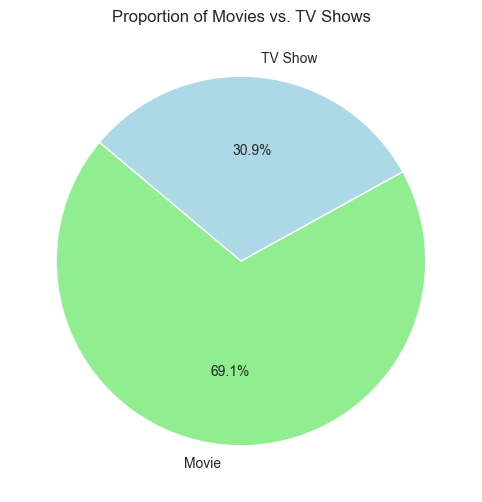

In [44]:
plt.figure(figsize=(8, 6))
type_counts = netflix_df['type'].value_counts()
plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightblue'])
plt.title('Proportion of Movies vs. TV Shows')
plt.ylabel('')
plt.show()

**Insight:** The Netflix library is dominated by Movies, which make up roughly 70% of the content in this dataset.

#### 4.2 How has content been added over time?

<Figure size 1400x800 with 0 Axes>

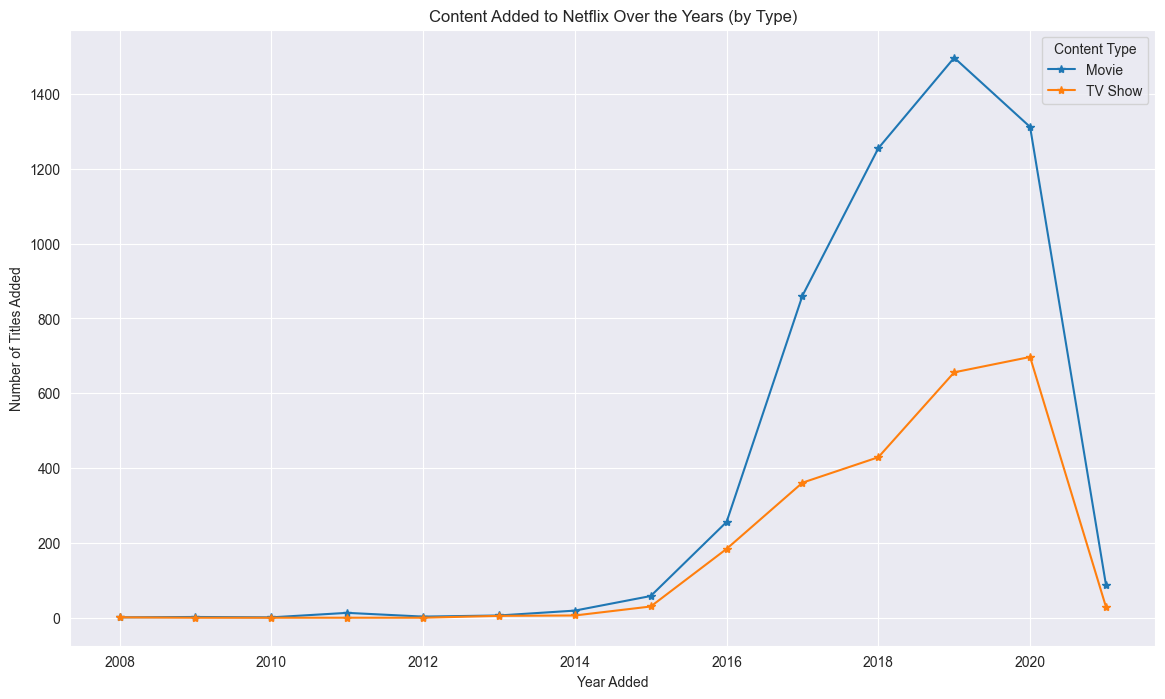

In [45]:
# Group data by year and content type
content_over_time = netflix_df.groupby(['year_added', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(14, 8))
content_over_time.plot(kind='line', marker='*', figsize=(14, 8))
plt.title('Content Added to Netflix Over the Years (by Type)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles Added')
plt.legend(title='Content Type')
plt.grid(True)
plt.show()

**Insight:** By separating movies and TV shows, we can see that while both grew significantly, the addition of movies accelerated much more dramatically, peaking in 2019. The growth in TV shows has been more steady. There appears to be a slight slowdown in content additions in 2020 and 2021, which could be due to the COVID-19 pandemic affecting productions or the dataset being incomplete for the latest year.

In [46]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


#### 4.3 What are the most popular genres?

#### **Theoretical Concept: Handling Multi-Value Text Columns**
The `listed_in` column contains strings with multiple genres separated by commas (e.g., "Dramas, International Movies"). To analyze each genre individually, we need to transform the data. A common technique is to:
1.  **Split** the string in each row into a list of genres.
2.  **Explode** the DataFrame so that each genre in the list gets its own row, duplicating the other information for that title.
This allows us to perform a `value_counts()` on the genres.

In [47]:
# Split the 'listed_in' column and explode it
genres = netflix_df.assign(genre=netflix_df['listed_in'].str.split(', ')).explode('genre')

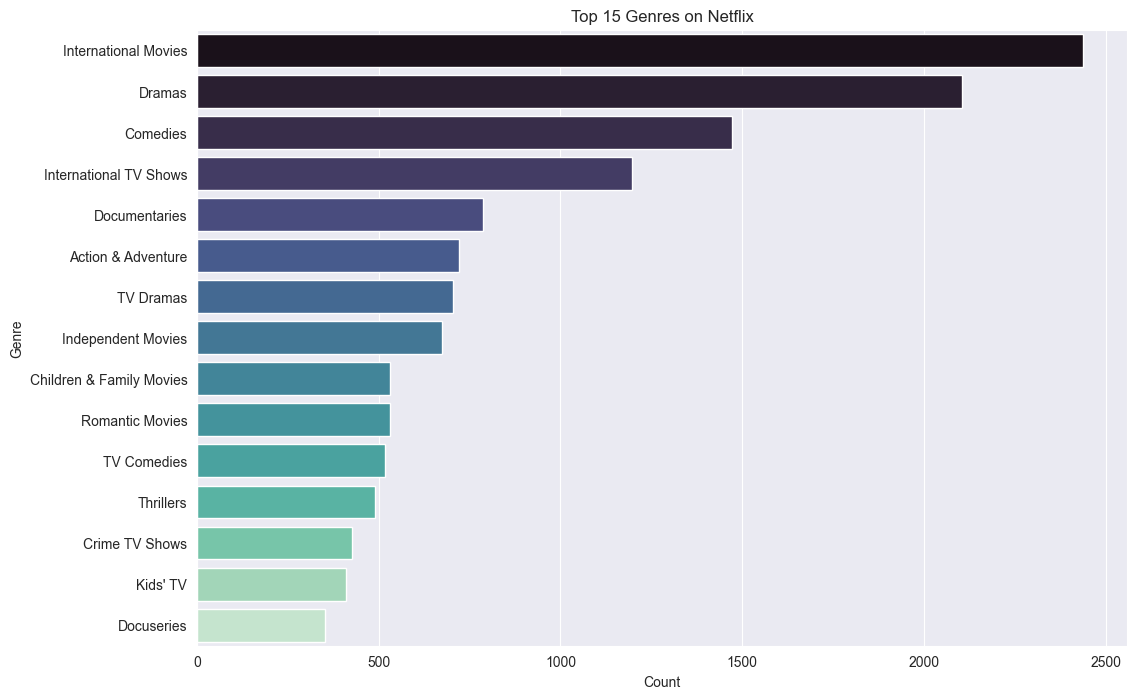

In [48]:
# Get the top 15 genres and their counts
top_genres_counts = genres['genre'].value_counts().reset_index()
top_genres_counts.columns = ['genre', 'count'] # Rename columns for clarity

# Select only the top 15 for plotting
top_genres_counts_plot = top_genres_counts.head(15)

plt.figure(figsize=(12, 8))
sns.barplot(y='genre', x='count', data=top_genres_counts_plot, palette='mako', hue='genre', legend=False)
plt.title('Top 15 Genres on Netflix')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.show()

**Insight:** "International Movies" is the most common genre tag, highlighting Netflix's global content strategy. This is followed by Dramas, Comedies, and Action & Adventure.

#### 4.4 What is the distribution of content duration?

In [49]:
# Separate movies and TV shows
movies_df = netflix_df[netflix_df['type'] == 'Movie'].copy()
tv_shows_df = netflix_df[netflix_df['type'] == 'TV Show'].copy()

In [50]:
# Clean and convert duration for movies
movies_df['duration_min'] = movies_df['duration'].str.replace(' min', '').astype(int)

# Clean and convert duration for TV shows
tv_shows_df['seasons'] = tv_shows_df['duration'].str.replace(' Seasons', '').str.replace(' Season', '').astype(int)

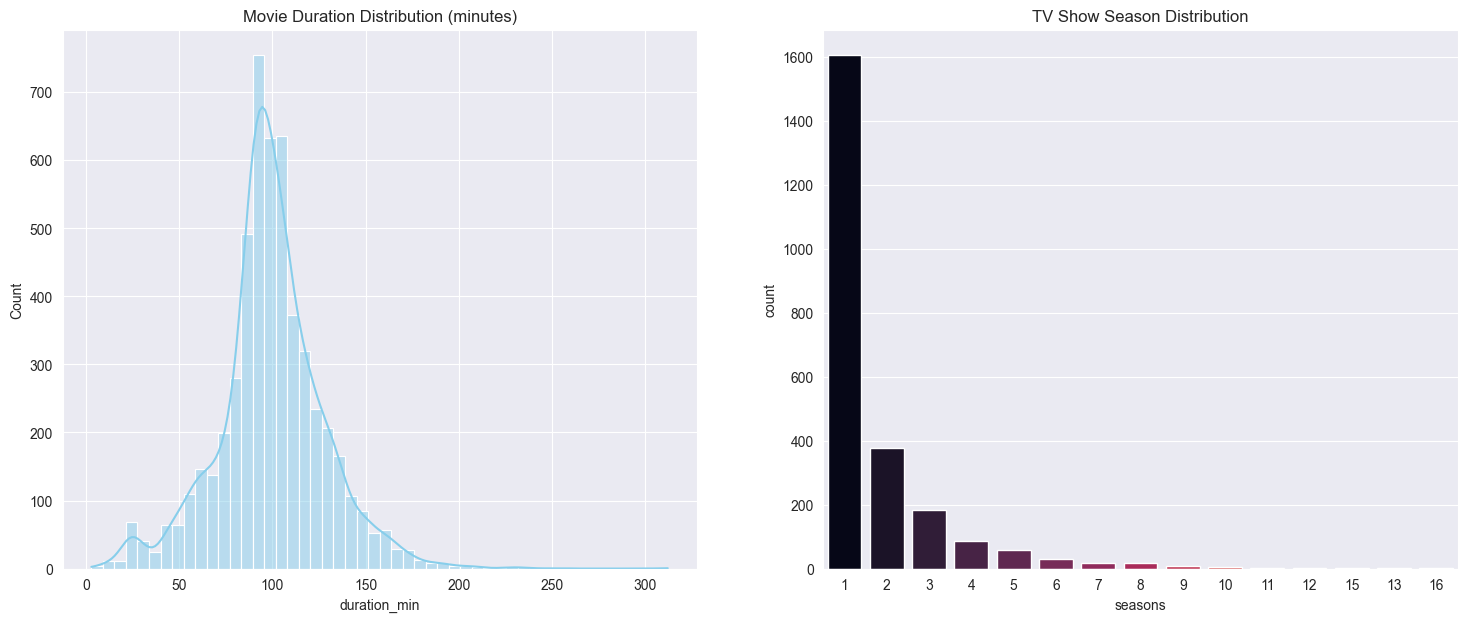

In [51]:
# Plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Movie Duration Distribution
sns.histplot(ax=axes[0], data=movies_df, x='duration_min', bins=50, kde=True, color='skyblue').set_title('Movie Duration Distribution (minutes)')

# TV Show Season Distribution
sns.countplot(ax=axes[1], x='seasons', data=tv_shows_df, palette='rocket', order=tv_shows_df['seasons'].value_counts().index, hue='seasons', legend=False).set_title('TV Show Season Distribution')

plt.show()

**Insight:**
- The majority of movies on Netflix are between 80 and 120 minutes long, which is standard for feature films.
- The vast majority of TV shows on Netflix are short-lived, with most having only 1 season. This could reflect a strategy of producing many pilots and only renewing the most successful ones, or a focus on limited series.

#### 4.5 Where does the content come from? (Geographical Analysis)

In [52]:
# Handle the multi-country listings similar to genres
countries = netflix_df.assign(country=netflix_df['country'].str.split(', ')).explode('country')

In [53]:
# Get the top 15 countries and their counts
top_countries_counts = countries['country'].value_counts().reset_index()
top_countries_counts.columns = ['country', 'count'] # Rename columns for clarity

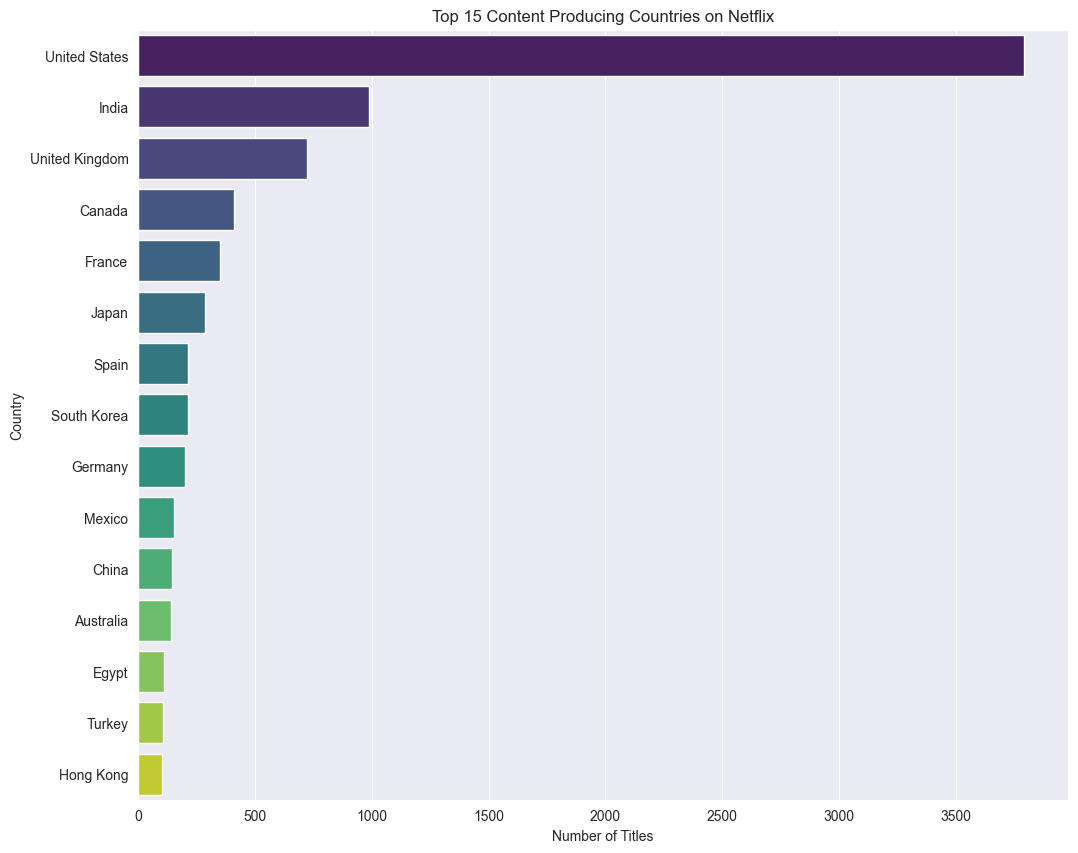

In [54]:
# Select only the top 15 for plotting
top_countries_counts_plot = top_countries_counts.head(15)

plt.figure(figsize=(12, 10))
sns.barplot(y='country', x='count', data=top_countries_counts_plot, palette='viridis', hue='country', legend=False)
plt.title('Top 15 Content Producing Countries on Netflix')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.show()

**Insight:** The United States is by far the largest producer of content available on Netflix. However, India is a very strong second, which explains why so many of the top actors were from India. The UK, Japan, and South Korea also represent major content markets for the platform, emphasizing its global nature.

In [55]:
netflix_df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
0,s1,TV Show,3%,Unknown,"João Miguel, Bianca Comparato, Michel Gomes, R...",Brazil,2020-08-14,2020,TV-MA,4 Seasons,"International TV Shows, TV Dramas, TV Sci-Fi &...",In a future where the elite inhabit an island ...,2020,8
1,s2,Movie,7:19,Jorge Michel Grau,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016-12-23,2016,TV-MA,93 min,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...,2016,12


#### 4.6 What are the maturity ratings of the content?

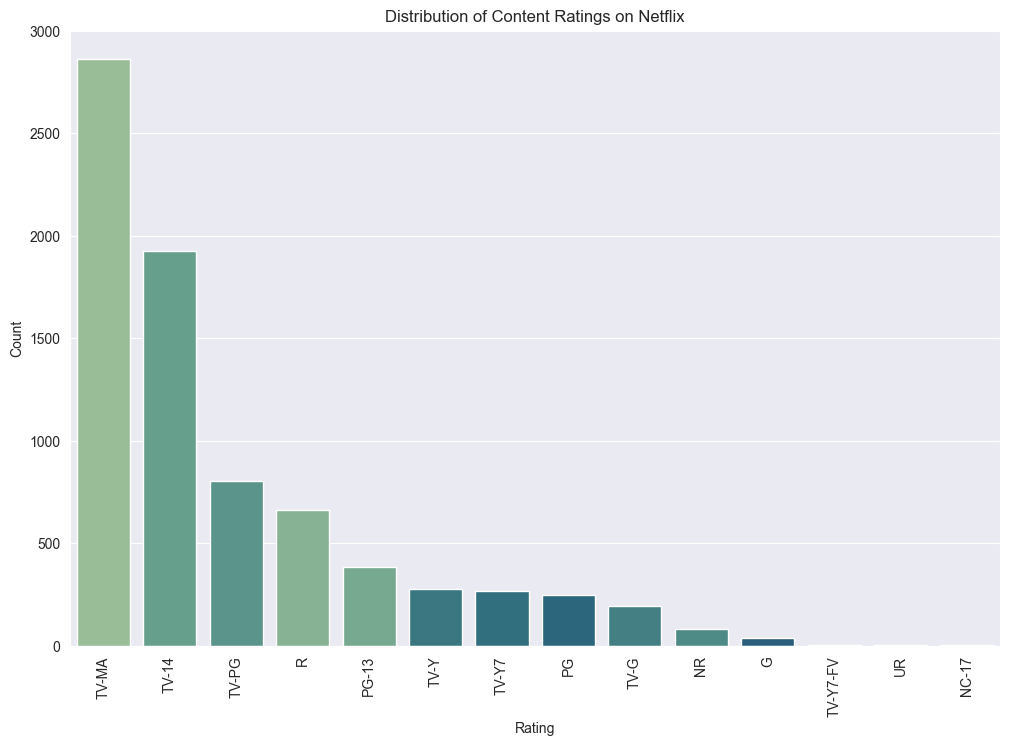

In [56]:
plt.figure(figsize=(12, 8))
sns.countplot(x='rating', data=netflix_df, order=netflix_df['rating'].value_counts().index, palette='crest', hue='rating', legend=False)
plt.title('Distribution of Content Ratings on Netflix')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

**Insight:** A large portion of Netflix's content is aimed at mature audiences, with `TV-MA` (Mature Audience) and `TV-14` (Parents Strongly Cautioned) being the two most common ratings. This suggests a focus on adult viewers over content for children (`TV-G`, `TV-Y`).

### Step 5: Feature Engineering - Content Freshness
Let's create a new feature to analyze how old content is when it gets added to Netflix. This can tell us about their acquisition strategy (buying old classics vs. releasing new originals).

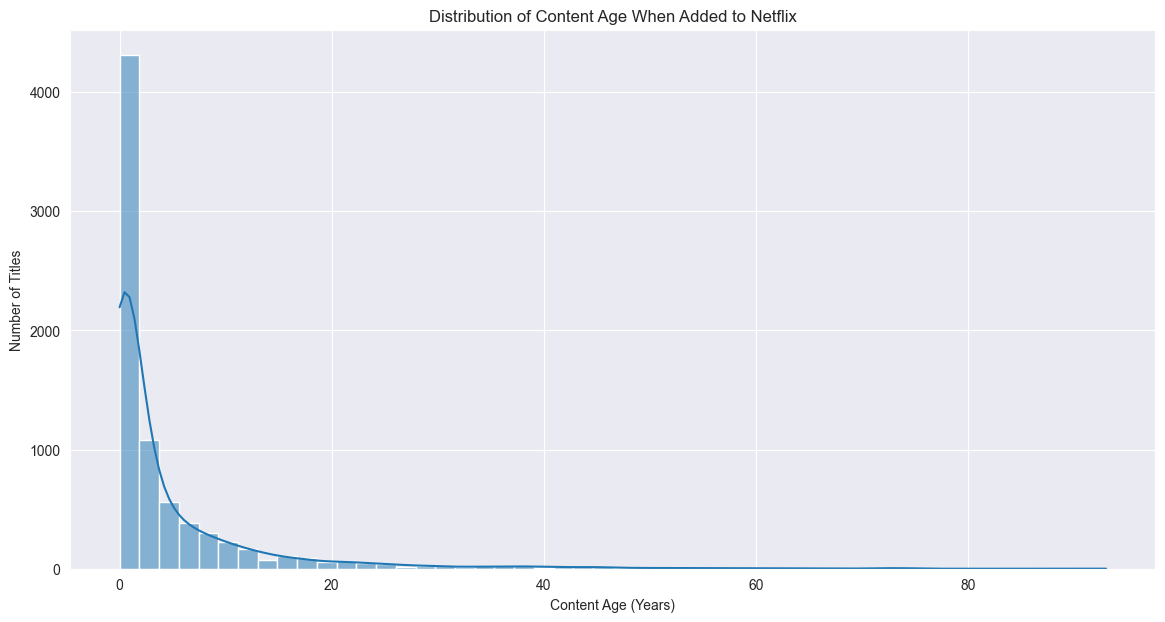

In [57]:
# Create the 'age_on_netflix' feature
netflix_df['age_on_netflix'] = netflix_df['year_added'] - netflix_df['release_year']

# Filter out any potential errors where added_year is before release_year
content_age = netflix_df[netflix_df['age_on_netflix'] >= 0]

plt.figure(figsize=(14, 7))
sns.histplot(data=content_age, x='age_on_netflix', bins=50, kde=True)
plt.title('Distribution of Content Age When Added to Netflix')
plt.xlabel('Content Age (Years)')
plt.ylabel('Number of Titles')
plt.show()

**Insight:** The large spike at `0` indicates that a significant amount of content is added in the same year it's released, which is characteristic of "Netflix Originals." However, there is a very long tail, showing that Netflix also heavily invests in acquiring licensed content that can be decades old, building a deep library of classic films and shows.

### Step 6: Deeper Multivariate Analysis

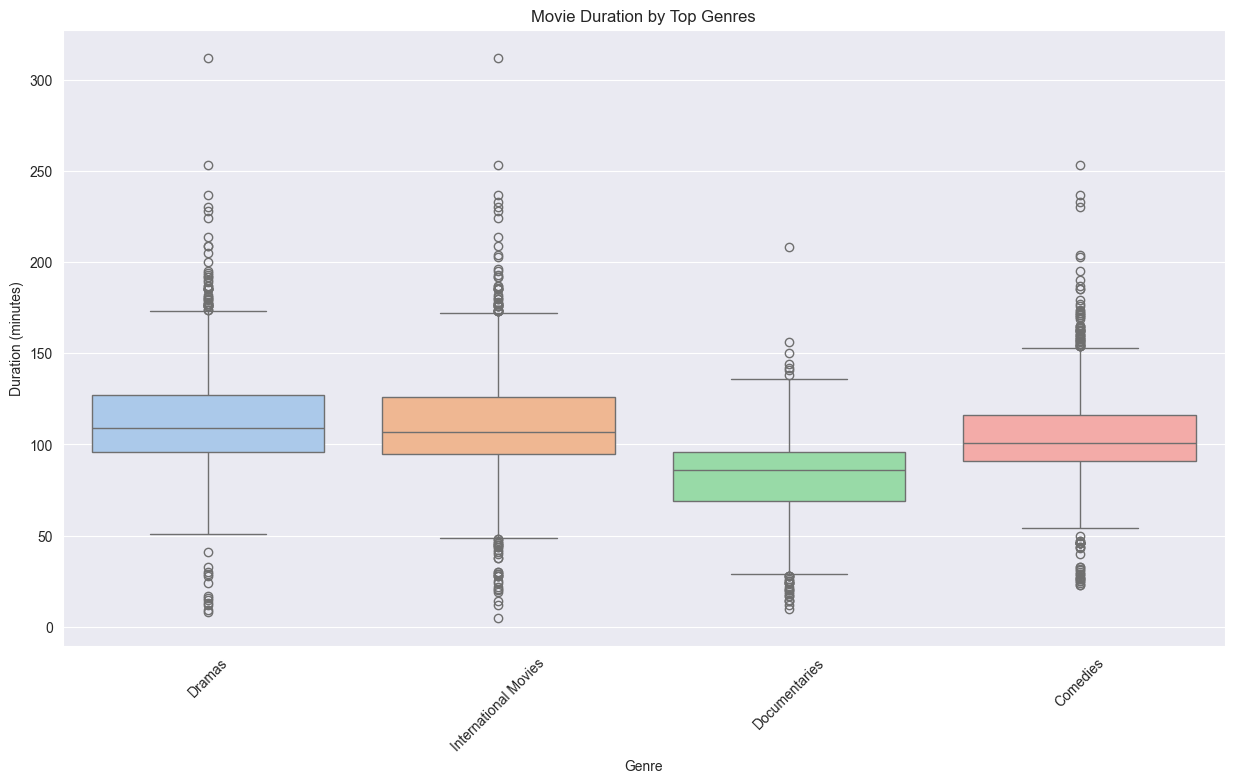

In [58]:
# Analyze movie duration across different top genres
top_genres = genres['genre'].value_counts().index[:5]
genres_movies = genres[(genres['type'] == 'Movie') & (genres['genre'].isin(top_genres))].copy()
genres_movies['duration_min'] = genres_movies['duration'].str.replace(' min', '').astype(int)

plt.figure(figsize=(15, 8))
sns.boxplot(data=genres_movies, x='genre', y='duration_min', palette='pastel', hue='genre', legend=False)
plt.title('Movie Duration by Top Genres')
plt.xlabel('Genre')
plt.ylabel('Duration (minutes)')
plt.xticks(rotation=45)
plt.show()

**Insight:** While the median duration for most top genres is similar (around 90-100 minutes), we can see some interesting variations. For example, Dramas tend to have a wider range of durations, with many longer films. International Movies also show a broad distribution, reflecting diverse filmmaking styles from around the world.

### Step 7: Word Cloud from Content Descriptions
As a final visual analysis, let's generate a word cloud from the `description` column to see what themes and words are most common in Netflix content.

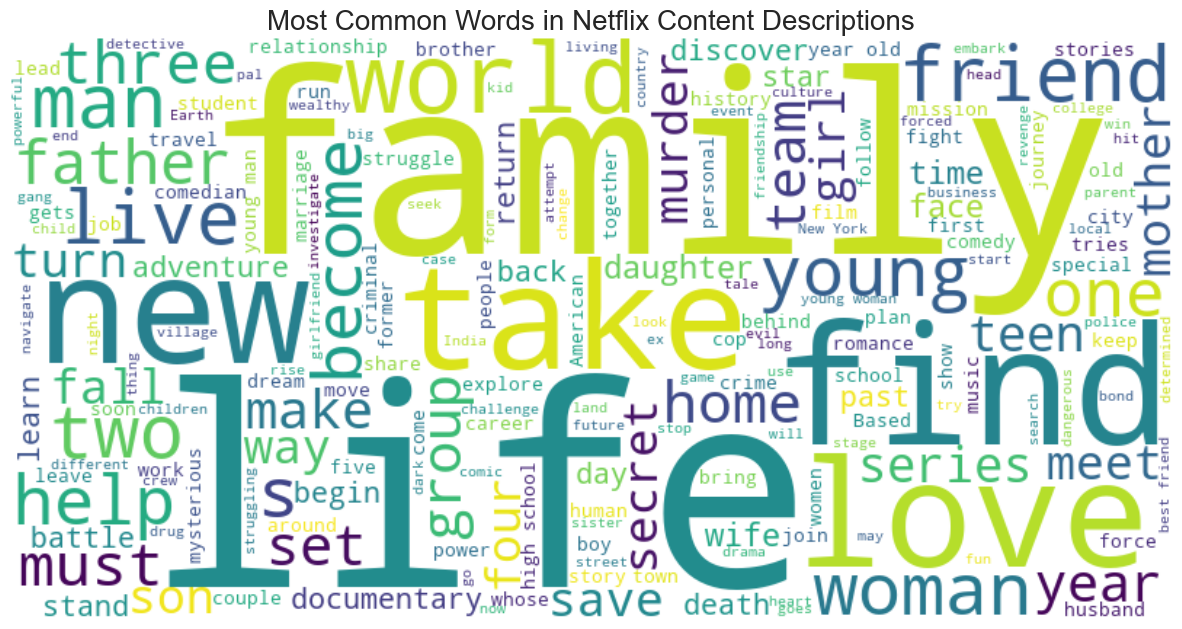

In [69]:
# Combine all descriptions into a single string
text = ' '.join(netflix_df['description'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated image
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in Netflix Content Descriptions', fontsize=20)
plt.show()

**Insight:** The word cloud highlights common themes and subjects. Words like "life," "family," "love," "young," "friends," and "world" are prominent, suggesting that much of the content revolves around human relationships and personal journeys. Action-oriented words like "find," "secret," and "new" also appear frequently.

### Step 8: Final Conclusion and Summary of Insights

This in-depth EDA of the Netflix dataset has revealed several key characteristics and strategies of the platform's content library.

**Key Findings:**
1.  **Content Strategy:** Netflix's library is movie-heavy (~70%), and the platform aggressively added content between 2016-2019. Their strategy involves a mix of brand new originals (added the same year they are released) and a deep library of licensed older content.
2.  **Global Dominance:** While the US is the top content producer, the platform is heavily international, with India being a massive contributor. This is reflected in the top genres ("International Movies") and most frequent actors.
3.  **Target Audience:** The content library is skewed towards mature audiences, with `TV-MA` and `TV-14` being the most common ratings.
4.  **Content Format & Genre:** Dramas and Comedies are universally popular genres. Most movies stick to a standard 90-120 minute runtime, while the vast majority of TV shows only last for a single season, suggesting a high-risk, high-reward approach to series production.
5.  **Common Themes:** Descriptions of content frequently revolve around universal themes of life, family, love, and discovery.

**Limitations:** This dataset is a snapshot in time and lacks viewership data. Therefore, our analysis is of the *supply* of content, not its *demand* or popularity. Nonetheless, this EDA provides a strong, multi-faceted understanding of the composition and evolution of the Netflix library.

# Submission Q's

* How has the distribution of content ratings changed over time?
* Is there a relationship between content age and its type (Movie vs. TV Show)?
* Can we identify any trends in content production based on the release year vs. the year added to Netflix?
* What are the most common word pairs or phrases in content descriptions?
* Who are the top directors on Netflix?

#### Q1. How has the distribution of content ratings changed over time?

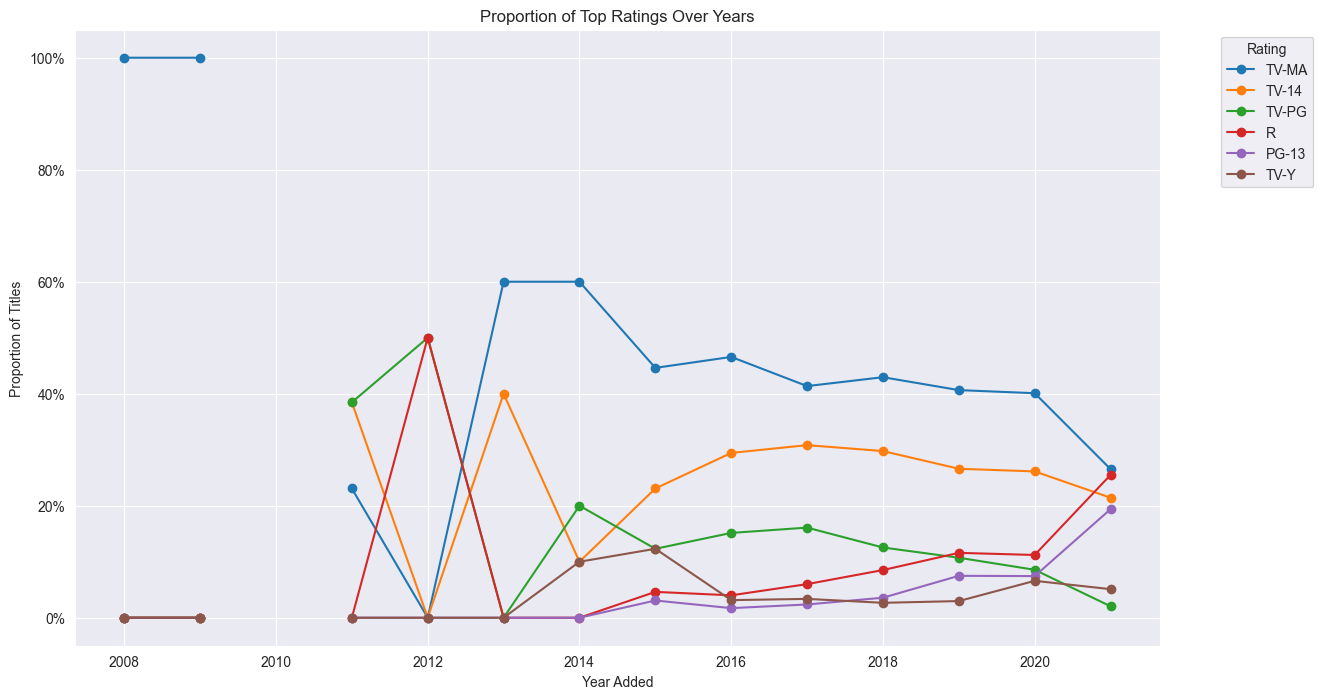

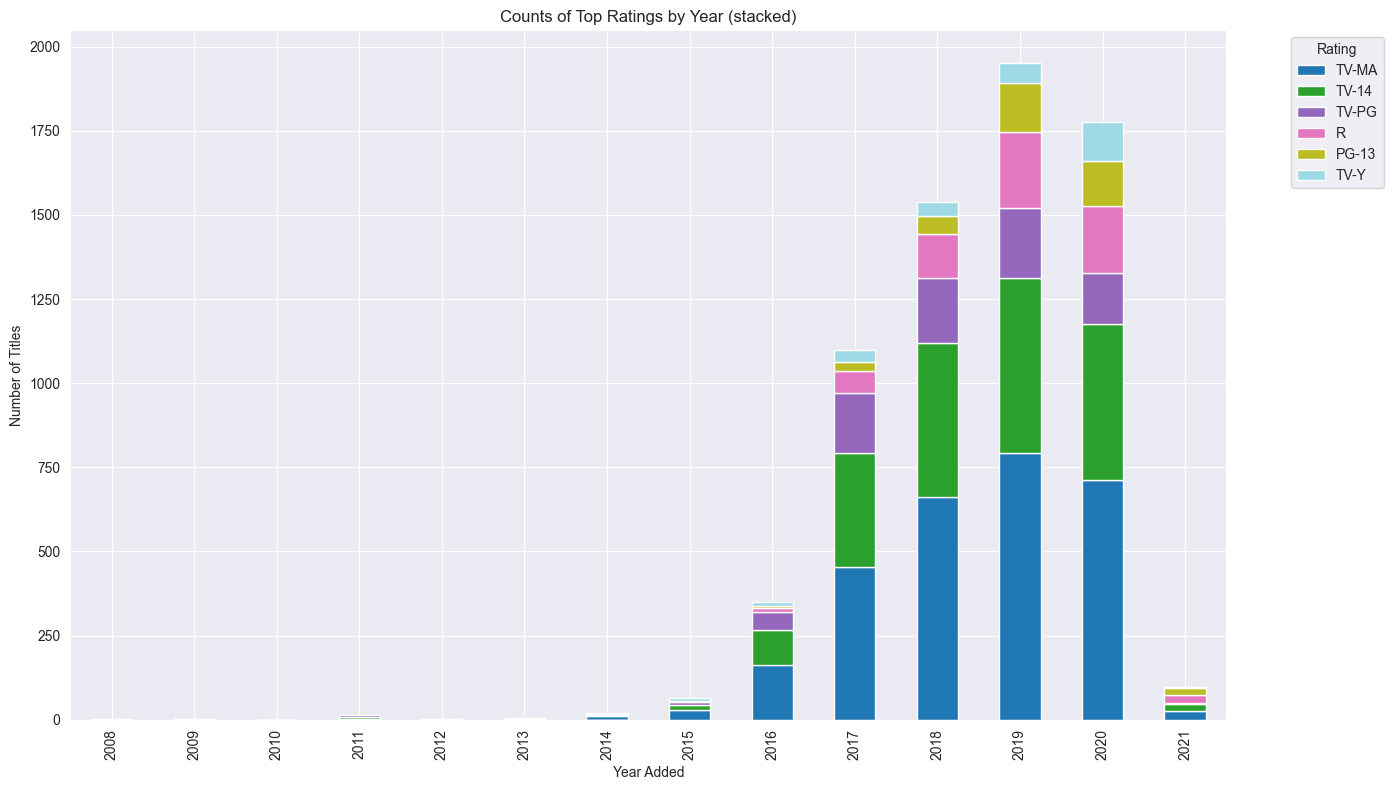

Years covered: 2008 to 2021
Top ratings plotted: ['TV-MA', 'TV-14', 'TV-PG', 'R', 'PG-13', 'TV-Y']


In [60]:
# Aggregate counts of ratings by the year content was added to Netflix
rating_over_time = netflix_df.groupby(['year_added', 'rating']).size().unstack(fill_value=0)
# Drop any NaN years and ensure index is integer-sorted
rating_over_time = rating_over_time[rating_over_time.index.notna()]
rating_over_time.index = rating_over_time.index.astype(int)
rating_over_time = rating_over_time.sort_index()
# Choose top ratings overall to keep plots readable
top_ratings = netflix_df['rating'].value_counts().index[:6].tolist()
rating_counts_top = rating_over_time.reindex(columns=top_ratings).fillna(0)
# Compute yearly proportions for the selected top ratings
rating_prop = rating_counts_top.div(rating_counts_top.sum(axis=1), axis=0)
import matplotlib.ticker as mtick
# Line plot showing proportion of each top rating over time
plt.figure(figsize=(14, 8))
for col in rating_prop.columns:
    plt.plot(rating_prop.index, rating_prop[col], marker='o', label=col)
plt.title('Proportion of Top Ratings Over Years')
plt.xlabel('Year Added')
plt.ylabel('Proportion of Titles')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()
# Stacked bar chart of counts for context
rating_counts_top.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='tab20')
plt.title('Counts of Top Ratings by Year (stacked)')
plt.xlabel('Year Added')
plt.ylabel('Number of Titles')
plt.legend(title='Rating', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
# Quick summary printout
print('Years covered:', rating_counts_top.index.min(), 'to', rating_counts_top.index.max())
print('Top ratings plotted:', top_ratings)

**Q1 — Key takeaways:**
- `TV-MA` and `TV-14` are the most frequent ratings overall (plotted among top ratings).
- The line plot shows how the *proportion* of top ratings changes year-to-year; the stacked bars show absolute volumes.
- Use the printed year range and the legend to identify specific years where shares shift noticeably.

#### Q2.Is there a relationship between content age and its type (Movie vs. TV Show)?

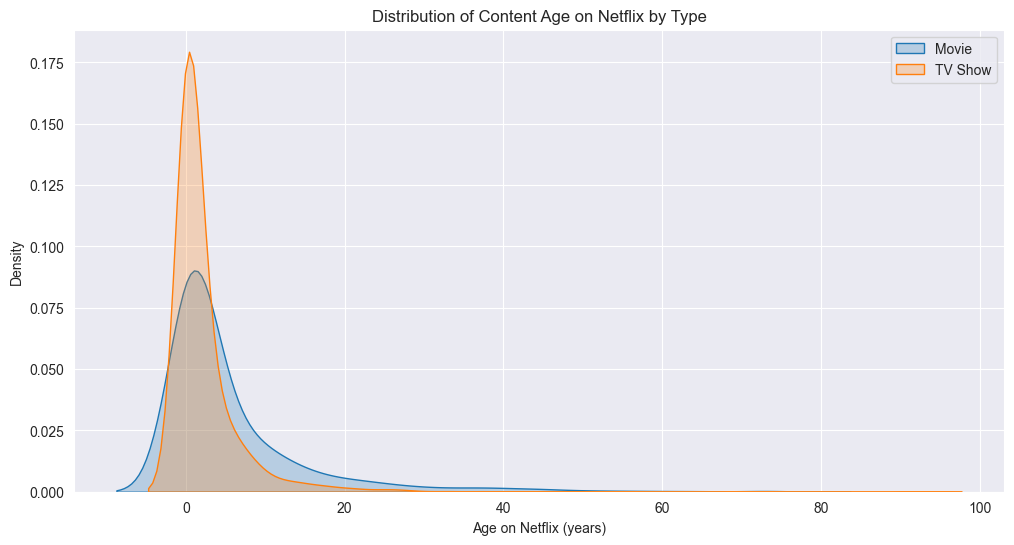

Median age (Movie): 1.0
Median age (TV Show): 0.0


In [61]:
# Use the 'age_on_netflix' feature created earlier and compare distributions
df_age = netflix_df[netflix_df['age_on_netflix'].notna() & (netflix_df['age_on_netflix'] >= 0)].copy()
movies_age = df_age[df_age['type'] == 'Movie']
tv_age = df_age[df_age['type'] == 'TV Show']
plt.figure(figsize=(12, 6))
sns.kdeplot(movies_age['age_on_netflix'], label='Movie', fill=True, bw_method=0.3),
sns.kdeplot(tv_age['age_on_netflix'], label='TV Show', fill=True, bw_method=0.3)
plt.title('Distribution of Content Age on Netflix by Type')
plt.xlabel('Age on Netflix (years)')
plt.legend()
plt.show()
# Summary statistics
print('Median age (Movie):', movies_age['age_on_netflix'].median())
print('Median age (TV Show):', tv_age['age_on_netflix'].median())

**Q2 — Key takeaways:**
- Movies show a strong peak near age 0, indicating many titles are added the same year they release (likely Netflix Originals).
- TV shows have a different, typically broader age distribution, suggesting more licensed or older series in the library.
- Median ages for each type are printed below — compare them to quantify the difference.

#### Q3. Can we identify any trends in content production based on the release year vs. the year added to Netflix?

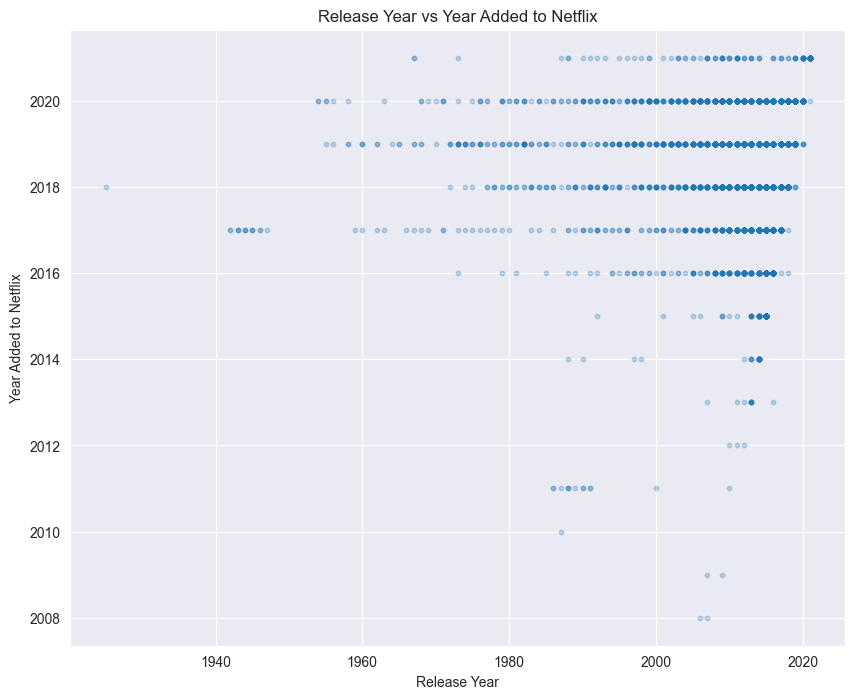

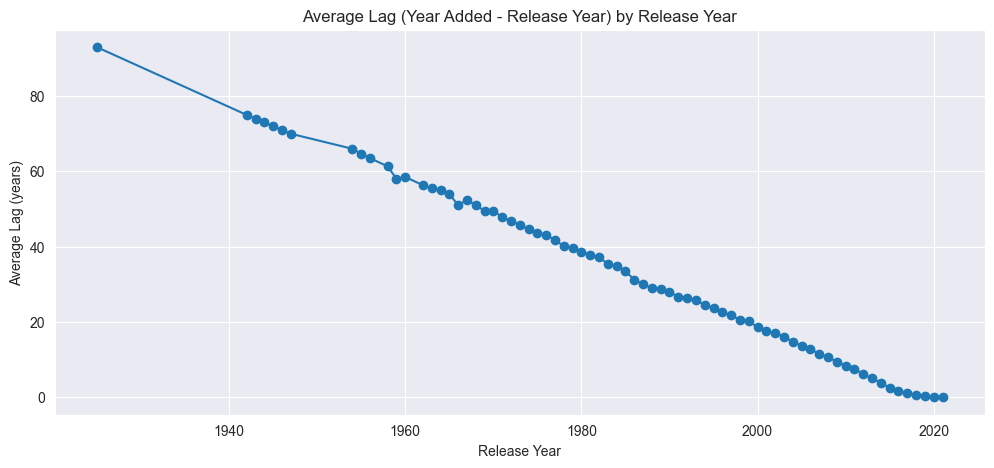

In [62]:
# Scatter to visualize relationship
plt.figure(figsize=(10, 8))
plt.scatter(netflix_df['release_year'], netflix_df['year_added'], alpha=0.25, s=10)
plt.xlabel('Release Year')
plt.ylabel('Year Added to Netflix')
plt.title('Release Year vs Year Added to Netflix')
plt.grid(True)
plt.show()
# Compute average lag (year_added - release_year) by release_year
netflix_df['lag'] = netflix_df['year_added'] - netflix_df['release_year']
lag_by_release = netflix_df.groupby('release_year')['lag'].mean().dropna()
plt.figure(figsize=(12, 5))
plt.plot(lag_by_release.index, lag_by_release.values, marker='o')
plt.title('Average Lag (Year Added - Release Year) by Release Year')
plt.xlabel('Release Year')
plt.ylabel('Average Lag (years)')
plt.grid(True)
plt.show()

**Q3 — Key takeaways:**
- The scatter of `release_year` vs `year_added` reveals many points along the diagonal (titles added near release year), plus a spread of older titles added later.
- The average `lag` plot (year_added - release_year) summarizes how the delay changes by release year — useful to spot shifts in acquisition vs. original production.
- Inspect the lag plot to see whether recent release years have smaller average lag (more originals).

#### Q4. What are the most common word pairs or phrases in content descriptions?

In [63]:
!pip install scikit-learn

/var/folders/q6/4fp22wjx0nxf0xh3rw357v0r0000gn/T/ipykernel_27192/4220392519.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='bigram', data=bigrams_df, palette='magma')


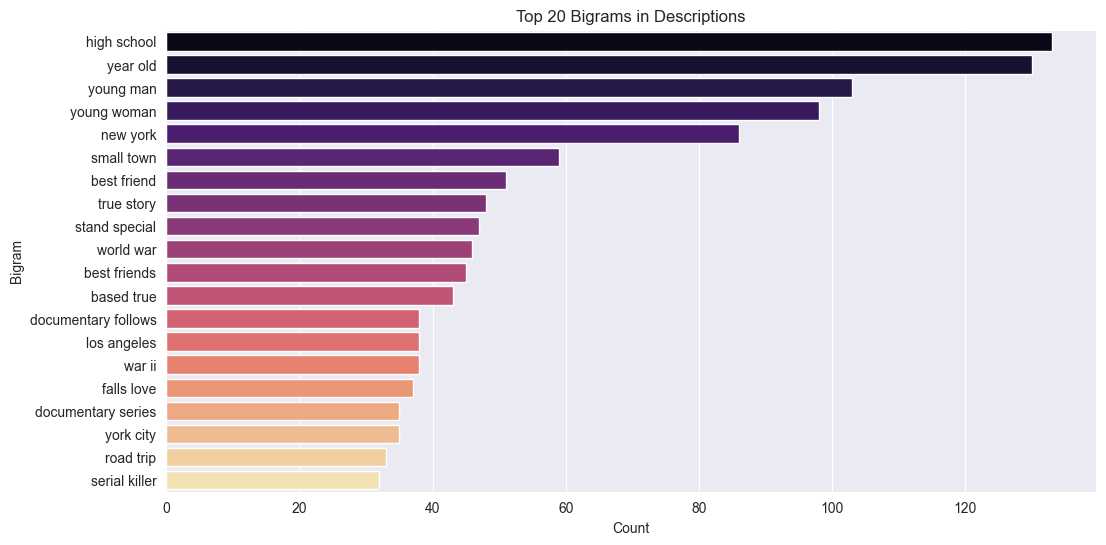

       bigram  count
  high school    133
     year old    130
    young man    103
  young woman     98
     new york     86
   small town     59
  best friend     51
   true story     48
stand special     47
    world war     46


In [64]:
from sklearn.feature_extraction.text import CountVectorizer
descriptions = netflix_df['description'].fillna('').astype(str)
cv = CountVectorizer(stop_words='english', ngram_range=(2,2), max_features=2000)
X = cv.fit_transform(descriptions)
sums = X.sum(axis=0).A1
terms = cv.get_feature_names_out()
bigram_counts = sorted(list(zip(terms, sums)), key=lambda x: x[1], reverse=True)[:20]
bigrams_df = pd.DataFrame(bigram_counts, columns=['bigram', 'count'])
plt.figure(figsize=(12, 6))
sns.barplot(x='count', y='bigram', data=bigrams_df, palette='magma')
plt.title('Top 20 Bigrams in Descriptions')
plt.xlabel('Count')
plt.ylabel('Bigram')
plt.show()
print(bigrams_df.head(10).to_string(index=False))

**Q4 — Key takeaways:**
- The bigram bar chart and printed table surface the most common 2-word phrases in descriptions (stop words removed).
- These bigrams reveal recurring themes (relationships, journeys, conflict); inspect the printed top bigrams to see exact phrases.
- Consider expanding n-grams or cleaning domain-specific tokens for deeper phrase insights.

#### Q5. Who are the top directors on Netflix?

/var/folders/q6/4fp22wjx0nxf0xh3rw357v0r0000gn/T/ipykernel_27192/4244537032.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_directors.values, y=top_directors.index, palette='cool')


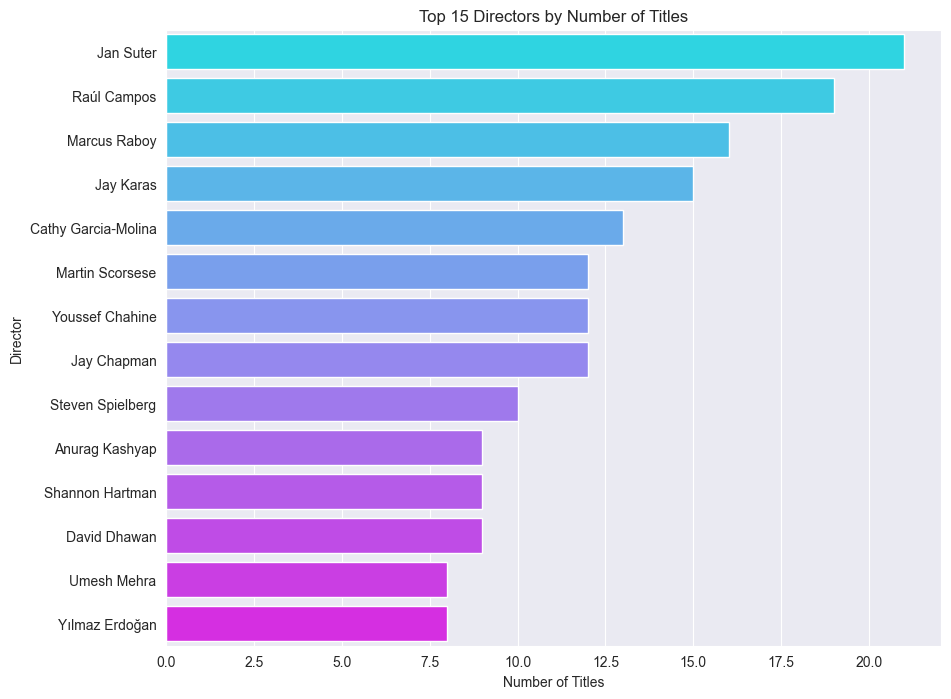

Top 10 directors: director
Jan Suter              21
Raúl Campos            19
Marcus Raboy           16
Jay Karas              15
Cathy Garcia-Molina    13
Martin Scorsese        12
Youssef Chahine        12
Jay Chapman            12
Steven Spielberg       10
Anurag Kashyap          9


In [65]:
# Split multi-director entries and count
directors = netflix_df.assign(director=netflix_df['director'].fillna('Unknown').str.split(', ')).explode('director')
top_directors = directors['director'].value_counts().head(15)
# filter out 'Unknown' if present
top_directors = top_directors[top_directors.index != 'Unknown']

plt.figure(figsize=(10, 8))
sns.barplot(x=top_directors.values, y=top_directors.index, palette='cool')
plt.title('Top 15 Directors by Number of Titles')
plt.xlabel('Number of Titles')
plt.ylabel('Director')
plt.show()
print('Top 10 directors:', top_directors.head(10).to_string())

**Q5 — Key takeaways:**
- The bar chart shows the top directors by title count (we filtered out `Unknown`).
- The printed top-10 gives exact counts — useful to identify prolific contributors on Netflix.
- Further analysis could weight directors by production year or content type to find influential directors for originals vs licensed content.

**Conclusion (Short, point-wise):**
- **Library composition:** The dataset is movie-heavy (≈70%), with movies dominating additions.
- **Growth trend:** Content additions accelerated up to ~2019, then slowed (possible dataset cutoff/COVID impact).
- **Originals vs licensed:** Large spike at age=0 shows many Netflix Originals are added the same year they release; licensed content spans many years.
- **Geography:** The U.S. is the top content producer, with strong international contributions (notably India).
- **Audience targeting:** Ratings skew toward mature audiences (TV-MA, TV-14).
- **Format patterns:** Most movies are ~90–120 minutes; most TV shows have only 1 season in this snapshot.
- **Common themes:** Descriptions emphasize relationships and personal stories (words like life, family, love).
- **Limitations:** This is a supply-side snapshot without viewership metrics; treat findings as descriptive rather than causal.